## Setup

In [1]:
import sys, phate, itertools, torch
sys.path.append('/home/aarthivenkat/AAnet/')
from AAnet_torch import *
from torch import nn, optim
import matplotlib
import seaborn as sns

In [2]:
import numpy as np
import pickle as pkl
import graphtools as gt
import matplotlib.pyplot as plt
import scprep, scipy
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, linregress
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform

## Load Simulated Data and reduce dimensionality to visualize nonlinearity

In [126]:
data = data.StereoSphereProjection(n_components=3, simplex_radius=2, n_obs=2000)
sim_data = data.data
vertices = data.vertices
phate_op = phate.PHATE(random_state=0, n_components=3, knn=10)
data_phate = phate_op.fit_transform(sim_data)
vertices_phate = phate_op.transform(vertices)

Calculating PHATE...
  Running PHATE on 2000 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 1.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.76 seconds.
Calculated PHATE in 9.11 seconds.
Calculating KNN search...
Calculating affinities...


/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


## Result is a Simplex with curved edges. This nonlinearity in the simplex makes it hard for archetypal analysis methods to identify the correct archetypes (colored in red)

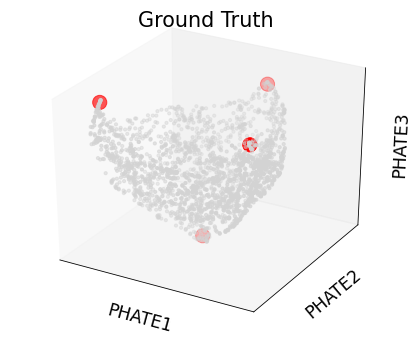

In [125]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE',title='Ground Truth',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None, s=10)
scprep.plot.scatter3d(vertices_phate,
                    c='red', ax=ax, s=200)
plt.tight_layout()

## AAnet

In [104]:
def train(sim_data, radius, gamma_extrema, vertices, colormap, extrema, run): 
    data_loader = torch.utils.data.DataLoader(sim_data, batch_size=128, shuffle=True, num_workers=4)
    device = torch.device('cpu')
    model = models.AAnet_vanilla(noise=0.05,
                                 n_archetypes=N_ARCHETYPES,
                                 layer_widths=[256, 128],
                                 input_shape=sim_data.shape[1],
                                 device=device,
                                 diffusion_extrema=extrema)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    n_row = 20
    n_col = 5
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
    min_loss = float('inf')
    min_r_loss = float('inf')
    min_a_loss = float('inf')
    min_epochs = 20
    patience = 20
    patience_counter = 0
    best_epochs = 0
    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            r_loss = a_loss = 0
            title='Untrained'
        else:
            # gamma_extrema parameter weights how informative graph-based extrema are to model
            loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i,
                                                   gamma_extrema=gamma_extrema)
            title='Epoch {}\nLoss={:.3E}'.format(i, loss)

            if (loss < min_loss and i < min_epochs):
                min_loss = loss
                min_r_loss = r_loss
                min_a_loss = a_loss
                patience_counter = 0
                best_epochs = i
                torch.save(model.state_dict(), f'{radius}_radius_model_{gamma_extrema}_extrema_{run}')
            elif i > min_epochs:
                patience_counter += 1
            
            if (patience_counter >= patience and i > min_epochs):
                break
                
            print (best_epochs, loss, min_loss, patience_counter)

        archetypal_embedding = model.encode(torch.Tensor(sim_data))

        scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
        scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
        ax.set_xlim(-1, 1.25)
        ax.set_ylim(-1, 1.25)

    fig.tight_layout()
    
    print(f'{radius}\t{gamma_extrema}\t{best_epochs}\t{min_loss}\t{min_r_loss}\t{min_a_loss}\n')

    eval(sim_data, radius, gamma_extrema, vertices, colormap, extrema, device, run)

In [105]:
def eval(sim_data, radius, gamma_extrema, vertices, colormap, extrema, device, run):     
    model = models.AAnet_vanilla(noise=0.05,
                                 n_archetypes=N_ARCHETYPES,
                                 layer_widths=[256, 128],
                                 input_shape=sim_data.shape[1],
                                 device=device,
                                 diffusion_extrema=extrema)

    ### LOAD BEST MODEL
    model.load_state_dict(torch.load(f'{radius}_radius_model_{gamma_extrema}_extrema_{run}'))
    
    archetypal_embedding = model.encode(torch.Tensor(sim_data))
    barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
    data_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
    phate_ats = phate_op.transform(data_ats)
    
    np.save(f'{radius}_radius_model_{gamma_extrema}_extrema_{run}_latent.npy', barycentric_archetypal_embedding)
    np.save(f'{radius}_radius_model_{gamma_extrema}_extrema_{run}_data_ats.npy', data_ats)
    np.save(f'{radius}_radius_model_{gamma_extrema}_extrema_{run}_phate_ats.npy', phate_ats)
    
    orders = list(itertools.permutations([0,1,2,3]))
    mse_ats_orders = []
    for order in orders:
        mse_ats = mean_squared_error(data_ats[:,order], vertices)
        mse_ats_orders.append(mse_ats)
        
    best_order = orders[np.argmin(mse_ats_orders)]
    best_mse = np.min(mse_ats_orders)
    r2_each_at = []
    for i in range(N_ARCHETYPES):
        result = linregress(data_ats[i,best_order], vertices[i])
        r2_each_at.append(result.rvalue)
    
    print(f'{radius}\t{gamma_extrema}\t{best_mse}\t{best_order}\t{np.mean(r2_each_at)}\n')
        
    fig = plt.figure(figsize=(16,5))
    axes = []
    for i in range(N_ARCHETYPES):
        axes.append(fig.add_subplot(141+i, projection='3d'))

    for i in range(N_ARCHETYPES):
        scprep.plot.scatter3d(data_phate, ax=axes[i], label_prefix='PHATE', title='AAnet',
                            azim=90, c=barycentric_archetypal_embedding[:,i], fontsize=8, colorbar=False, ticks=None)
        scprep.plot.scatter3d(vertices_phate,
                            c='red', azim=45, ax=axes[i], s=200)
        scprep.plot.scatter3d(phate_ats,
                            c='black', azim=45, ax=axes[i], s=200)

        axes[i].xaxis.labelpad = 0; axes[i].yaxis.labelpad = 0; axes[i].zaxis.labelpad = 0

In [106]:
N_ARCHETYPES = 4
extrema_id = np.array(utils.get_laplacian_extrema(sim_data, n_extrema=N_ARCHETYPES))
extrema = torch.FloatTensor(sim_data[extrema_id.astype(int)])

1 0.1637829034589231 0.1637829034589231 0
2 0.0852282871492207 0.0852282871492207 0
3 0.05814503785222769 0.05814503785222769 0
4 0.04027565417345613 0.04027565417345613 0
5 0.02003751916345209 0.02003751916345209 0
6 0.014873455569613725 0.014873455569613725 0
7 0.01256600086344406 0.01256600086344406 0
8 0.01109279552474618 0.01109279552474618 0
9 0.010369111550971866 0.010369111550971866 0
10 0.010075313039124012 0.010075313039124012 0
11 0.00943398691015318 0.00943398691015318 0
12 0.008949394687078893 0.008949394687078893 0
13 0.008933661971241236 0.008933661971241236 0
14 0.00865073167369701 0.00865073167369701 0
15 0.008528537058737129 0.008528537058737129 0
16 0.007948902697535232 0.007948902697535232 0
16 0.008013352053239942 0.007948902697535232 0
18 0.007470929034752771 0.007470929034752771 0
19 0.007322589197428897 0.007322589197428897 0
19 0.006932427466381341 0.007322589197428897 0
19 0.006987763365032151 0.007322589197428897 1
19 0.006482079916168004 0.007322589197428897

/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


1 0.1680843811482191 0.1680843811482191 0
2 0.09378557978197932 0.09378557978197932 0
3 0.058602820383384824 0.058602820383384824 0
4 0.03335324942599982 0.03335324942599982 0
5 0.017152852553408593 0.017152852553408593 0
6 0.01324176590424031 0.01324176590424031 0
7 0.01089597528334707 0.01089597528334707 0
8 0.009433894767425954 0.009433894767425954 0
9 0.008340889704413712 0.008340889704413712 0
10 0.007778024795698002 0.007778024795698002 0
11 0.0073390315810684115 0.0073390315810684115 0
12 0.007031218585325405 0.007031218585325405 0
13 0.006835648731794208 0.006835648731794208 0
14 0.006744259997503832 0.006744259997503832 0
14 0.00675611017504707 0.006744259997503832 0
16 0.006410461908672005 0.006410461908672005 0
17 0.0063154613599181175 0.0063154613599181175 0
17 0.006375748896971345 0.0063154613599181175 0
19 0.006126442545792088 0.006126442545792088 0
19 0.0060786965186707675 0.006126442545792088 0
19 0.006454599468270317 0.006126442545792088 1
19 0.005972912214929238 0.006

/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


1 0.150397767778486 0.150397767778486 0
2 0.06733307358808815 0.06733307358808815 0
3 0.032532213372178376 0.032532213372178376 0
4 0.021628416376188397 0.021628416376188397 0
5 0.01743700134102255 0.01743700134102255 0
6 0.014019540743902326 0.014019540743902326 0
7 0.011513241101056337 0.011513241101056337 0
8 0.009632835746742785 0.009632835746742785 0
9 0.008645169174997136 0.008645169174997136 0
10 0.008346640388481319 0.008346640388481319 0
11 0.007504543464165181 0.007504543464165181 0
12 0.007066810998367146 0.007066810998367146 0
13 0.006605282222153619 0.006605282222153619 0
14 0.006589907192392275 0.006589907192392275 0
15 0.006285556766670197 0.006285556766670197 0
15 0.006611060875002295 0.006285556766670197 0
17 0.00622783339349553 0.00622783339349553 0
18 0.006199546012794599 0.006199546012794599 0
18 0.006411200272850692 0.006199546012794599 0
18 0.0058777496160473675 0.006199546012794599 0
18 0.006000566354487091 0.006199546012794599 1
18 0.0059653870994225144 0.006199

/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


1 0.1637537688948214 0.1637537688948214 0
2 0.05670405167620629 0.05670405167620629 0
3 0.02072890638373792 0.02072890638373792 0
4 0.014385814545676112 0.014385814545676112 0
5 0.0099862395436503 0.0099862395436503 0
6 0.007922217686427757 0.007922217686427757 0
7 0.006942348292795941 0.006942348292795941 0
8 0.006593838625121862 0.006593838625121862 0
9 0.006475513568148017 0.006475513568148017 0
10 0.006390020425897092 0.006390020425897092 0
11 0.006091979303164408 0.006091979303164408 0
12 0.006073360360460356 0.006073360360460356 0
12 0.006194836838403717 0.006073360360460356 0
12 0.00620863918447867 0.006073360360460356 0
12 0.0063084124703891575 0.006073360360460356 0
16 0.006072989053791389 0.006072989053791389 0
17 0.006067617185181007 0.006067617185181007 0
17 0.006127035012468696 0.006067617185181007 0
17 0.006233773281564936 0.006067617185181007 0
17 0.006160510965855792 0.006067617185181007 0
17 0.005979630310321227 0.006067617185181007 1
17 0.00618886121083051 0.006067617

/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


1 0.1342586250975728 0.1342586250975728 0
2 0.0388099632691592 0.0388099632691592 0
3 0.021853818907402456 0.021853818907402456 0
4 0.018249664222821593 0.018249664222821593 0
5 0.014394097786862403 0.014394097786862403 0
6 0.01174780772998929 0.01174780772998929 0
7 0.010107064386829734 0.010107064386829734 0
8 0.008783067169133574 0.008783067169133574 0
9 0.0077676495420746505 0.0077676495420746505 0
10 0.007589141809148714 0.007589141809148714 0
11 0.006947635003598407 0.006947635003598407 0
11 0.007077014626702294 0.006947635003598407 0
13 0.0063457276846747845 0.0063457276846747845 0
13 0.006630240881349891 0.0063457276846747845 0
13 0.006461175158619881 0.0063457276846747845 0
16 0.006091815303079784 0.006091815303079784 0
17 0.006044561421731487 0.006044561421731487 0
17 0.0062147889111656696 0.006044561421731487 0
17 0.006219876668183133 0.006044561421731487 0
17 0.006021463283104822 0.006044561421731487 0
17 0.005883450852707028 0.006044561421731487 1
17 0.005902186181629077 0

/home/aarthivenkat/.local/lib/python3.8/site-packages/phate/phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


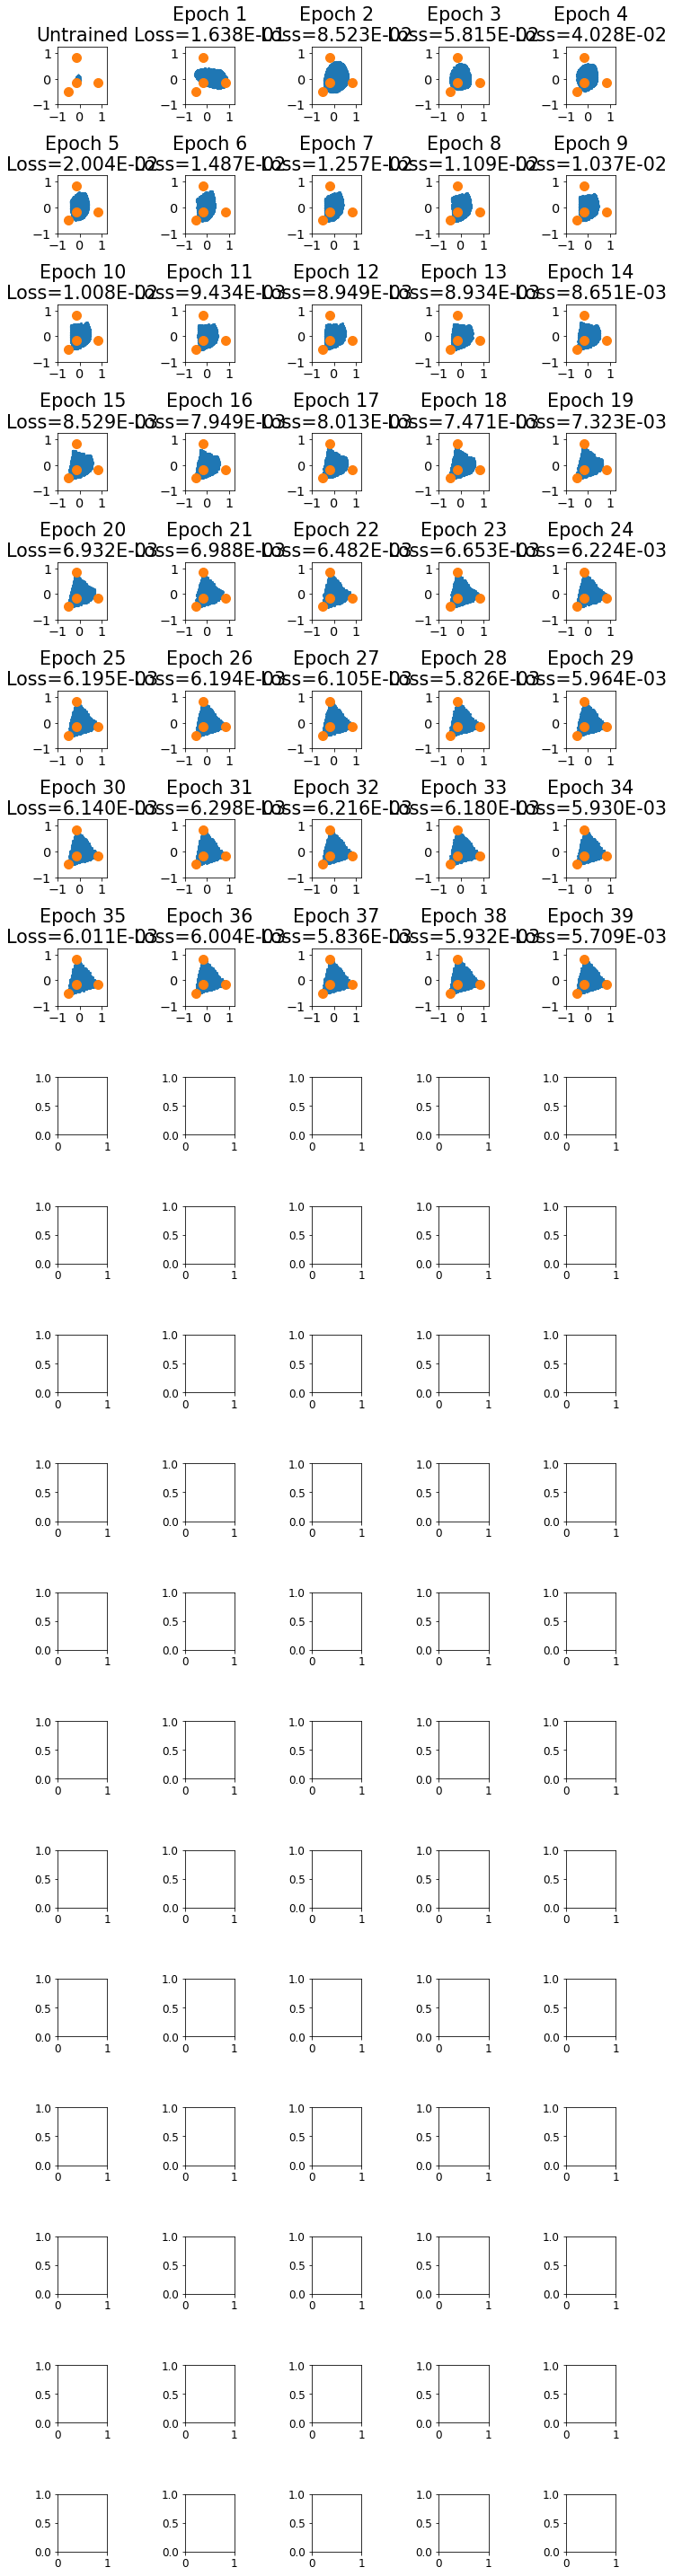

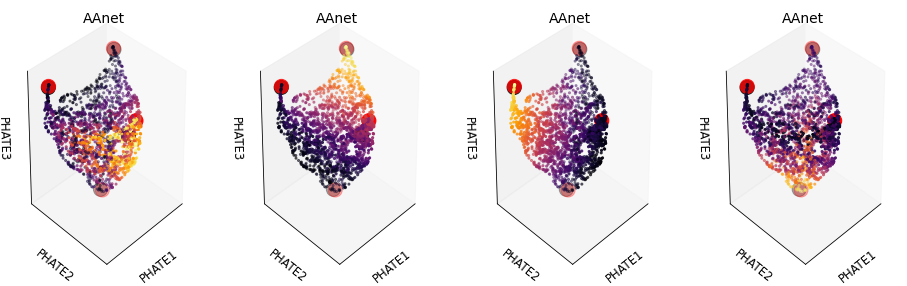

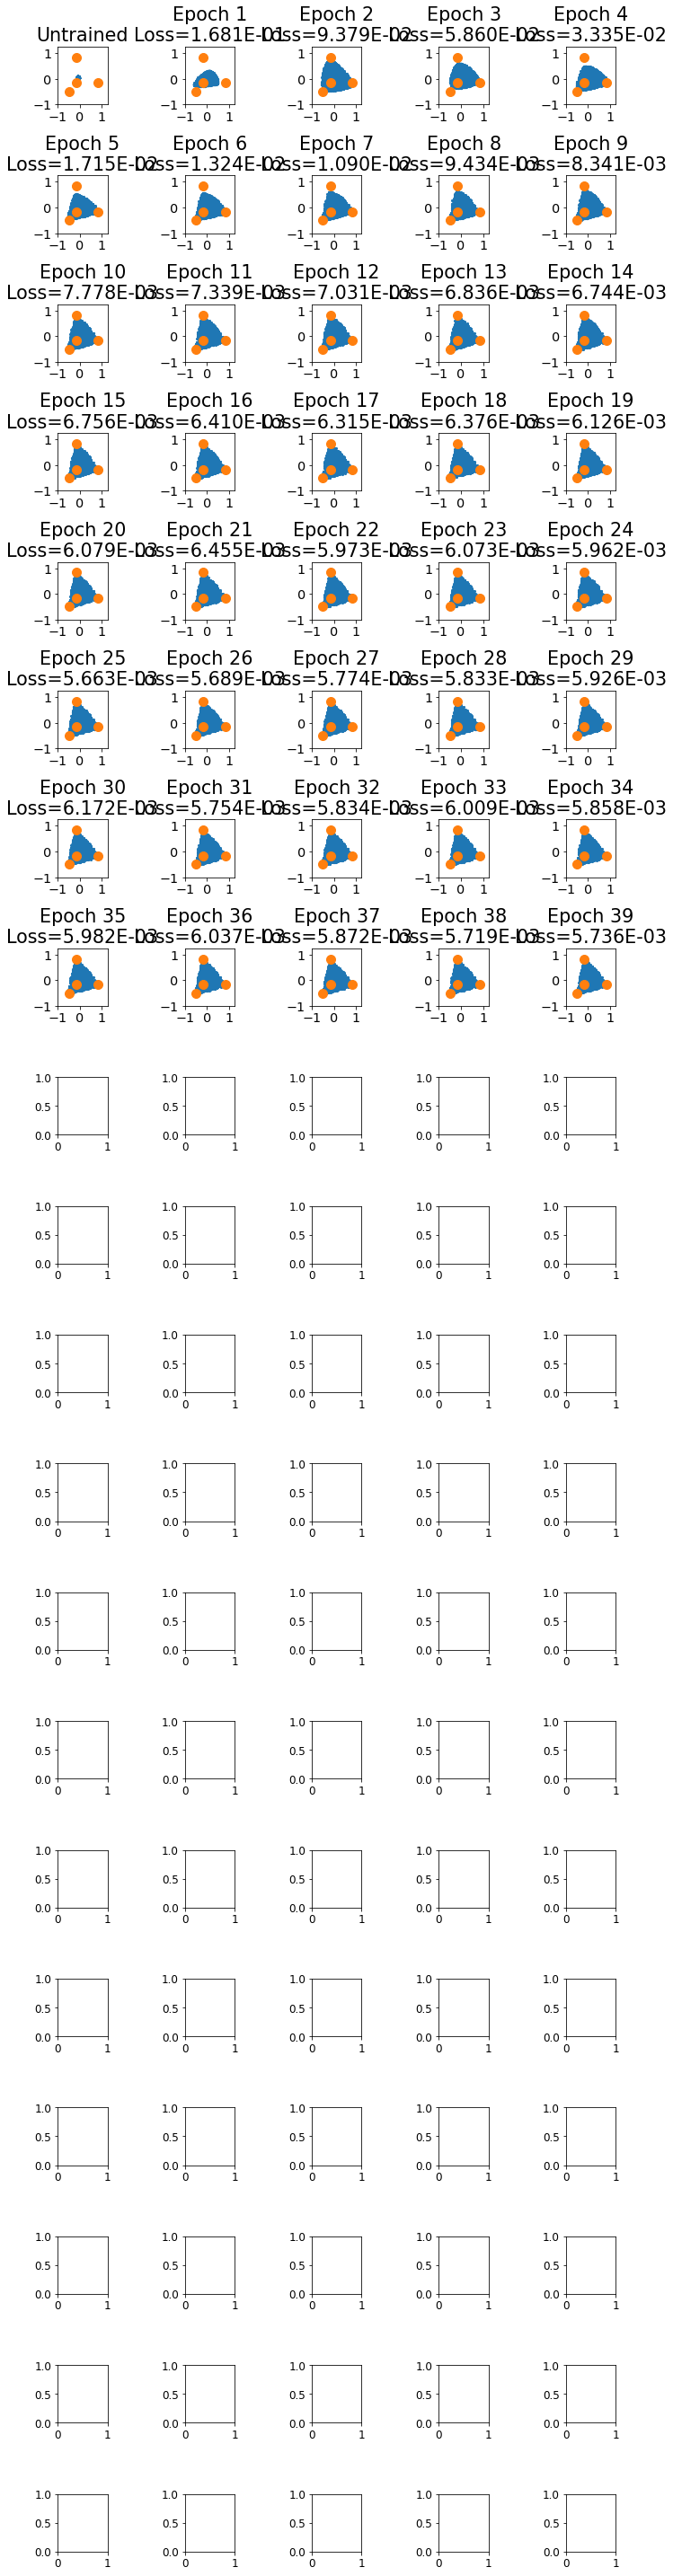

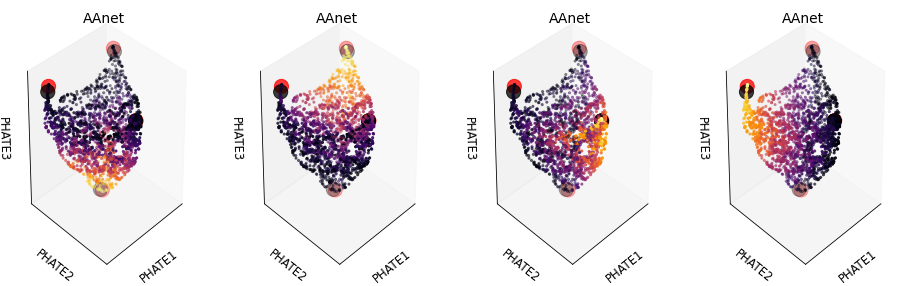

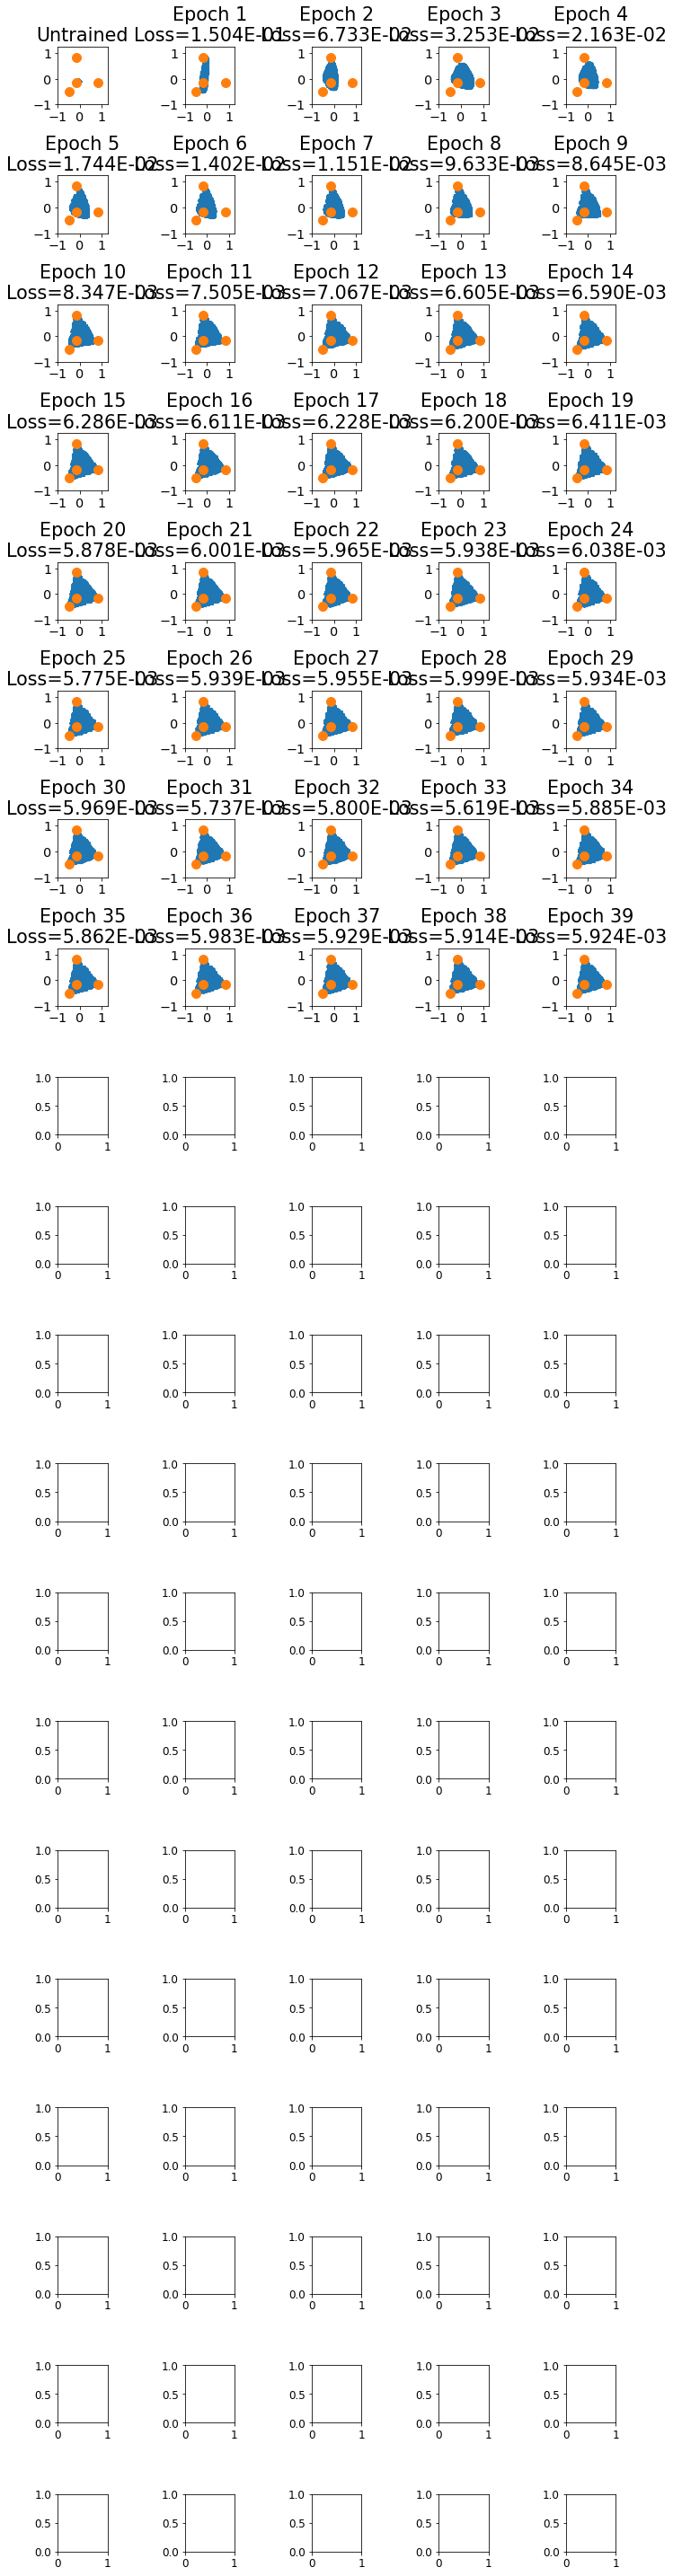

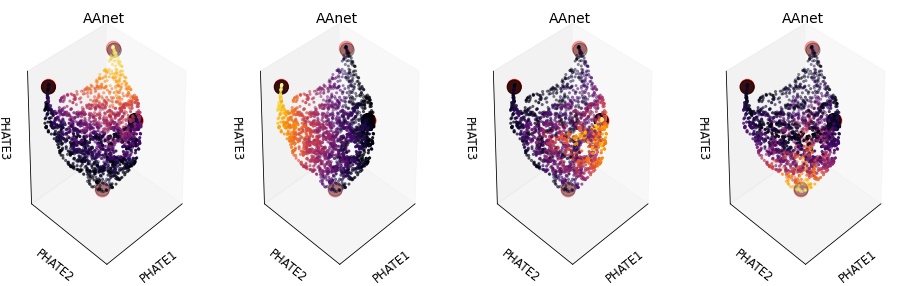

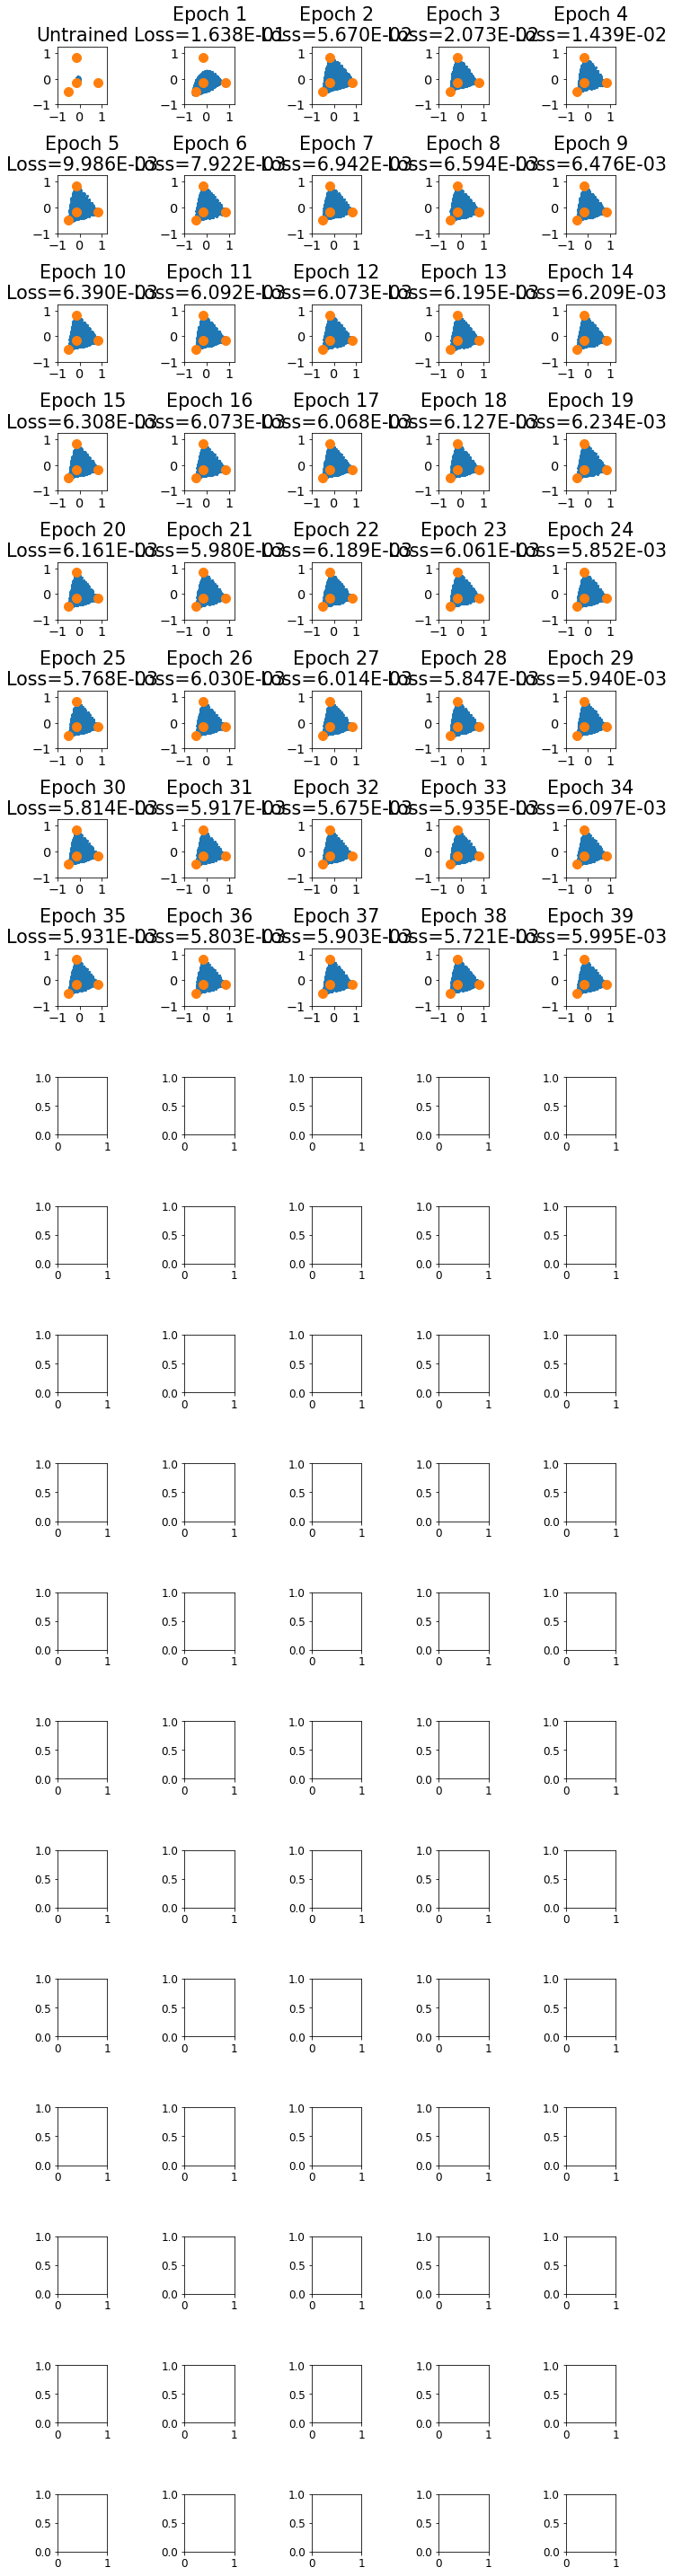

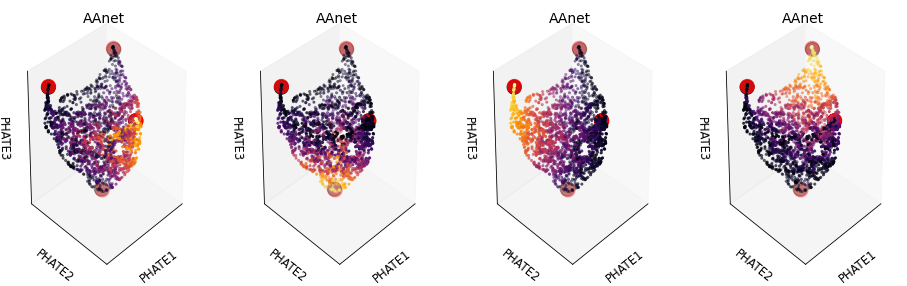

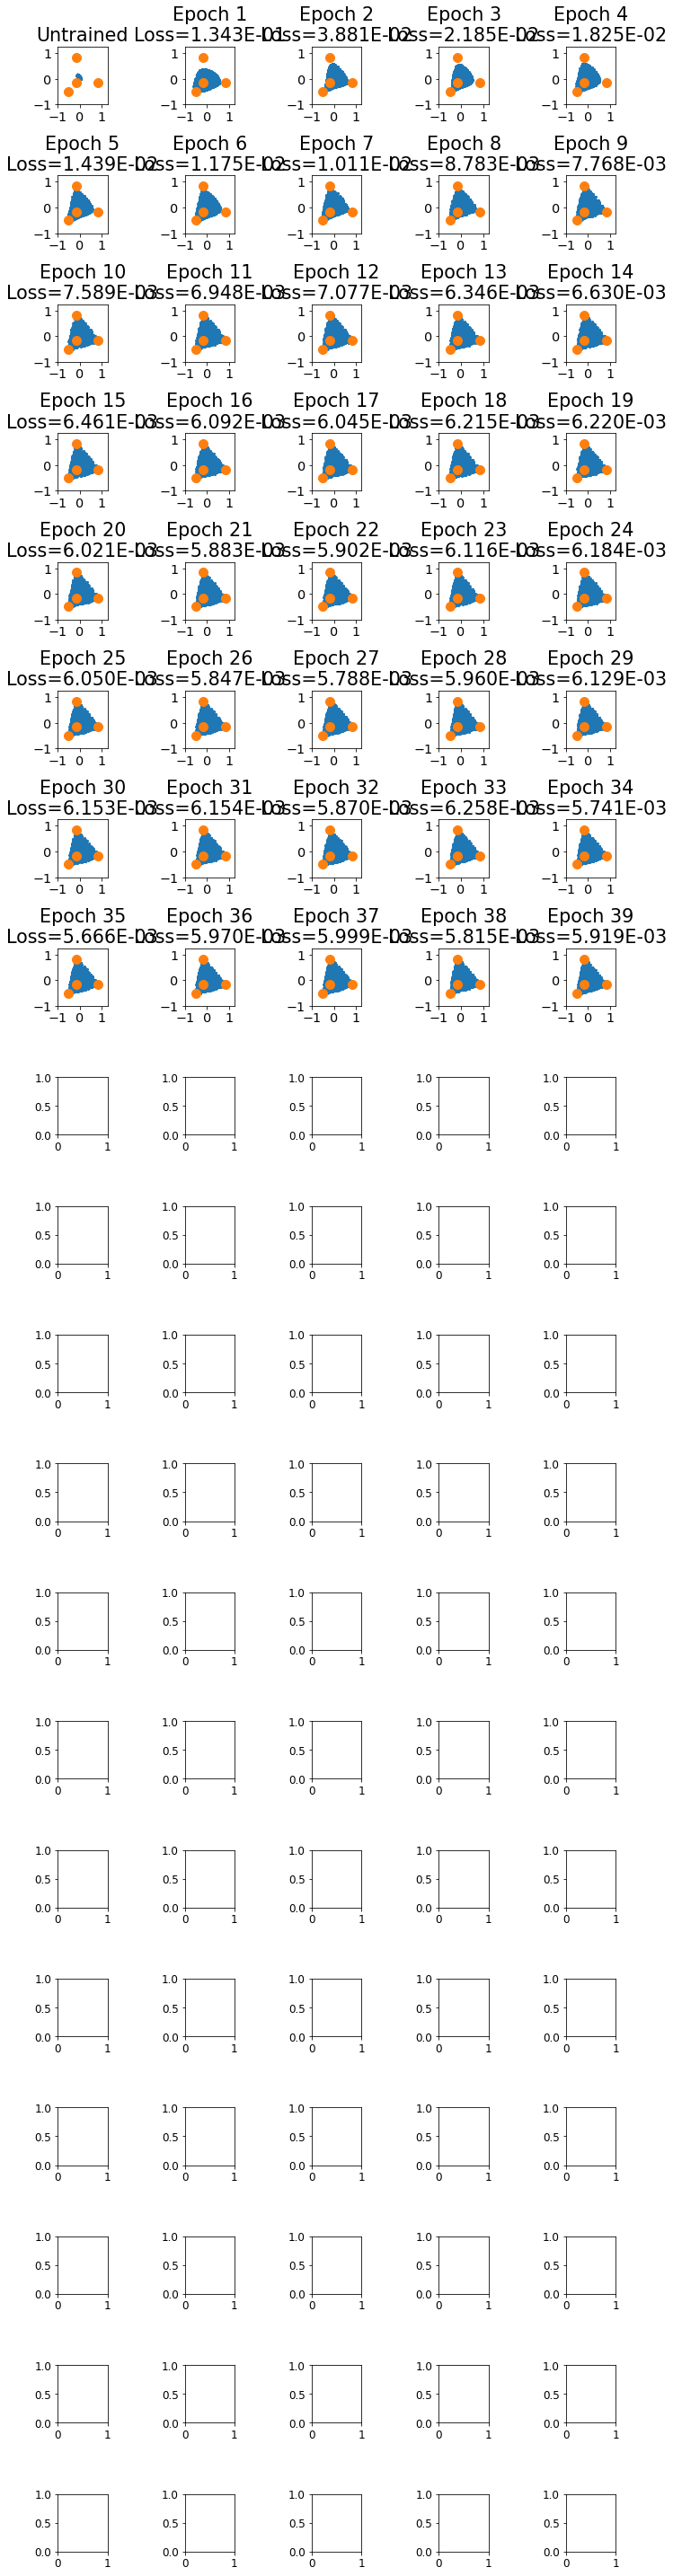

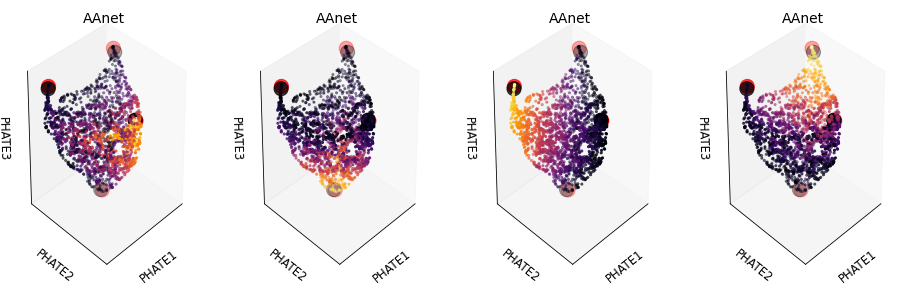

In [107]:
for run in range(5):
    train(torch.Tensor(sim_data), 2, 0, vertices, 'inferno', extrema, run)

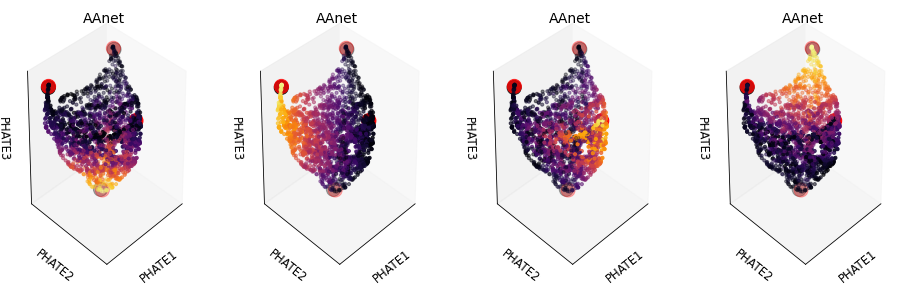

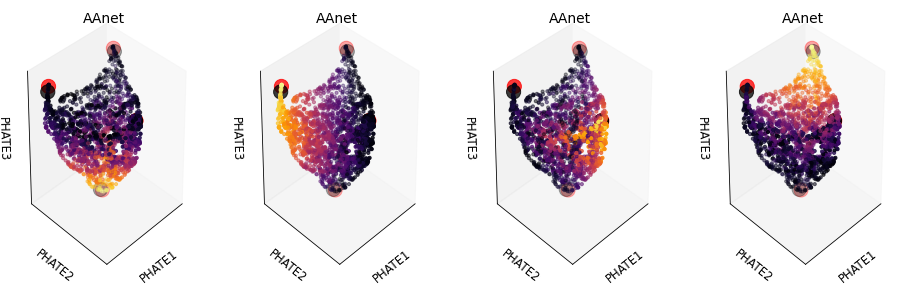

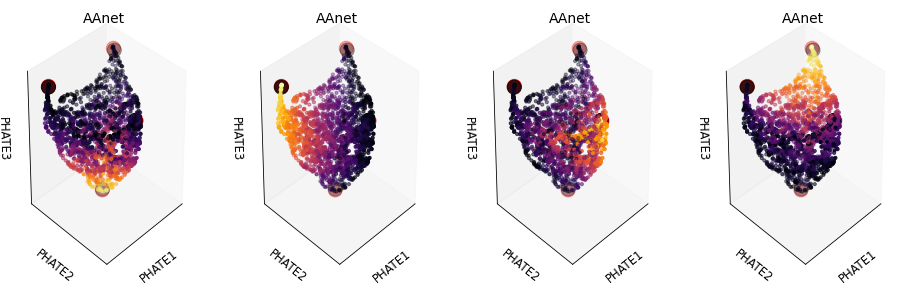

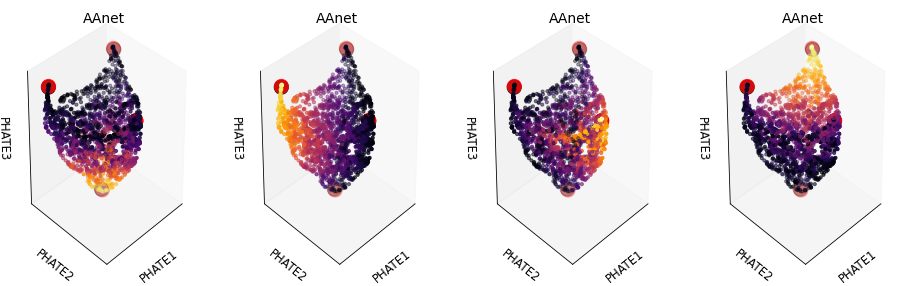

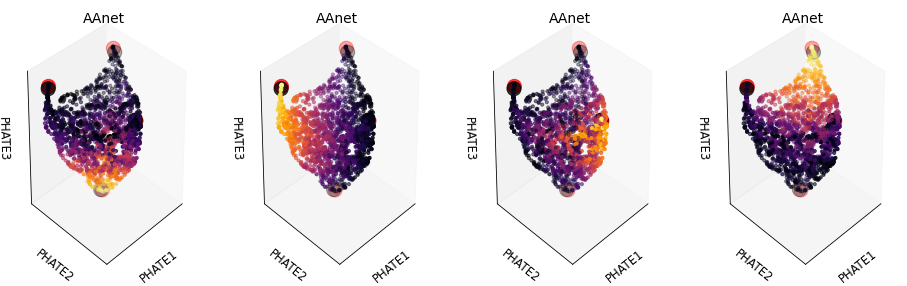

In [108]:
for run in range(5):
    phate_ats = np.load(f'2_radius_model_0_extrema_{run}_phate_ats.npy')
    fig = plt.figure(figsize=(16,5))
    axes = []
    for i in range(N_ARCHETYPES):
        axes.append(fig.add_subplot(141+i, projection='3d'))

    for i in range(N_ARCHETYPES):
        scprep.plot.scatter3d(data_phate, ax=axes[i], label_prefix='PHATE', title='AAnet',s=10,
                            azim=90, c=latent[:,i], fontsize=8, colorbar=False, ticks=None)
        scprep.plot.scatter3d(vertices_phate,
                            c='red', azim=45, ax=axes[i], s=200)
        scprep.plot.scatter3d(phate_ats,
                            c='black', azim=45, ax=axes[i], s=200)

        axes[i].xaxis.labelpad = 0; axes[i].yaxis.labelpad = 0; axes[i].zaxis.labelpad = 0

## AAnet successfully recovers archetypes.